# 1. Zaciągamy biblioteki które będziemy używać

In [427]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import tree, metrics, ensemble, linear_model, preprocessing
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

# 2. Zaciągamy dane z pliku i zmieniamy nazwy kolumn na bardziej wygodne do użycia

In [428]:
data = pd.ExcelFile('LGD.xlsx').parse()

In [429]:
data.columns = ["id", "lgd", "profile", "gotowka", "sald_deb", "sald_cre", "sald_avg", "sald_trend", "sald_sum", "zal_odset", "zal_kapital", "przyrost_kapital", "splat_kredyt", "stos_wartosci", "first_status", "type"]

# 3. Przygotowanie danych do analizy

In [430]:
data.isnull().sum()

id                     0
lgd                    0
profile                0
gotowka                2
sald_deb               0
sald_cre               0
sald_avg               0
sald_trend            34
sald_sum             240
zal_odset              0
zal_kapital            0
przyrost_kapital      34
splat_kredyt           1
stos_wartosci          0
first_status        1031
type                1017
dtype: int64

   ## 3.1 Czyszczenie danych
Widać że w kolumnach `first_status` i `type` jest dużo braków, więc my te kolumny wyrzucimy ze zbioru danych które będziemy analizować.
Dodatkowo nie potrzebujemy `id` i `lgd`, więc ich też pozbędziemy się.

In [431]:
data = data.drop(["id", "lgd", "first_status", "type"], axis=1)

In [432]:
data['profile'] = data['profile'].map({'N':False, 'T':True})

## 3.2 Uzupełnienie brakujących danych
Interpolujemy brakujące dane w tabeli.

In [433]:
data = data.interpolate()

In [434]:
data.isnull().sum()

profile             0
gotowka             0
sald_deb            0
sald_cre            0
sald_avg            0
sald_trend          0
sald_sum            0
zal_odset           0
zal_kapital         0
przyrost_kapital    0
splat_kredyt        0
stos_wartosci       0
dtype: int64

## 3.3 Podział danych na zbiór uczący i testowy

In [435]:
fractions = np.array([0.8, 0.2])
# shuffle your input
data = data.sample(frac=1, random_state=1) 
# split into 3 parts
train, test = np.array_split(
    data, (fractions[:-1].cumsum() * len(data)).astype(int))

In [436]:
Y_train = train["profile"]
train = train.drop(["profile"], axis=1)

In [437]:
Y_test = test["profile"]
test = test.drop(["profile"], axis=1)

In [438]:
print("Proporcja dobrych kredytobiorców do wszystkich w naszym zbiorze danych: {0:.2f}".format(data["profile"].sum() / data.shape[0]))
print("Czyli minimalnie skuteczny model musi dawać dobre wyniki w więcej niż {0:.2f} przypadkach.".format(1 - data["profile"].sum() / data.shape[0]))

Proporcja dobrych kredytobiorców do wszystkich w naszym zbiorze danych: 0.45
Czyli minimalnie skuteczny model musi dawać dobre wyniki w więcej niż 0.55 przypadkach.


In [439]:
train = preprocessing.normalize(train)
test = preprocessing.normalize(test)

## 3.4 Wstępna analiza danych

In [440]:
ourFrame = pd.DataFrame(preprocessing.normalize(data.drop(["profile"], axis=1)))

### Rozkład zmiennych

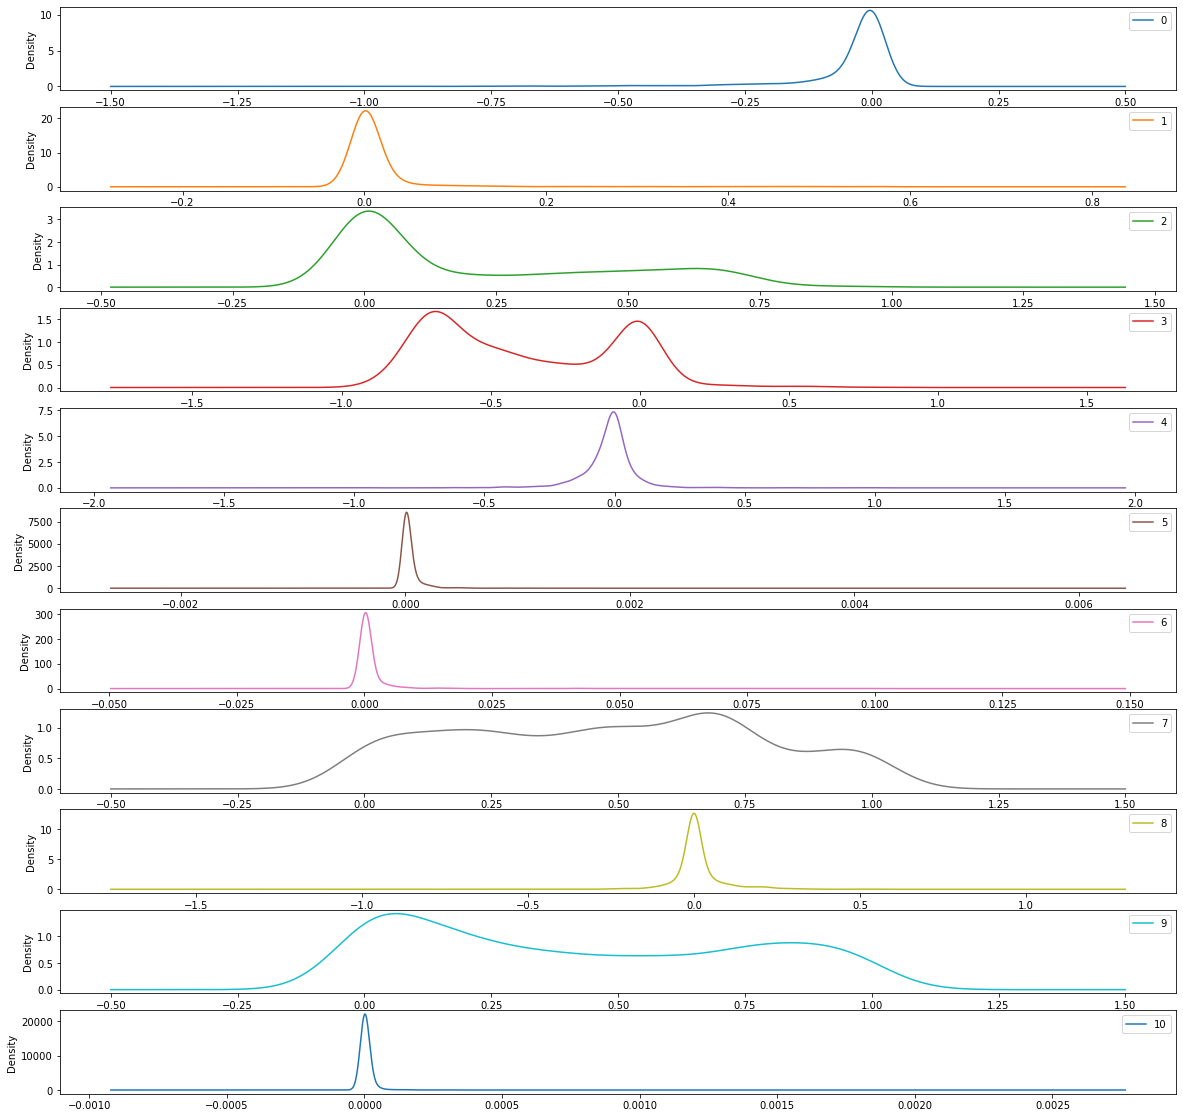

In [441]:
density = ourFrame.plot(kind='density',subplots=True,sharex=False, figsize=(20,20))

### Korelacja zmiennych

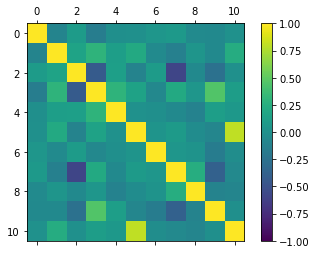

In [447]:
correlations=ourFrame.corr()
fig=plt.figure()
ax=fig.add_subplot(111)
cax=ax.matshow(correlations,vmin=-1,vmax=1)
_ = fig.colorbar(cax)

# 4. Analiza danych

In [376]:
clf = tree.DecisionTreeClassifier(max_depth=3)

In [377]:
clf = clf.fit(train, Y_train)

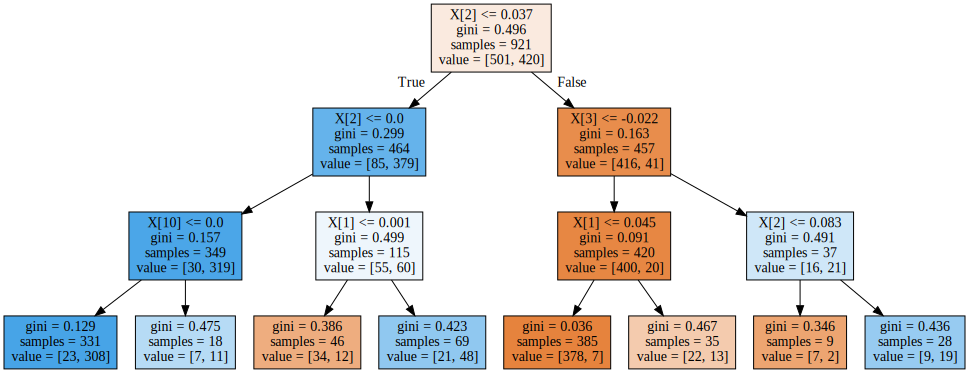

In [378]:
graph = Source(tree.export_graphviz(clf, out_file=None, filled = True))
display(SVG(graph.pipe(format='svg')))

In [379]:
test_prediction = clf.predict(test)

In [380]:
fpr, tpr, thresholds = metrics.roc_curve(Y_test, test_prediction)
roc_auc = metrics.auc(fpr, tpr)

In [381]:
roc_auc

0.8762083780880774

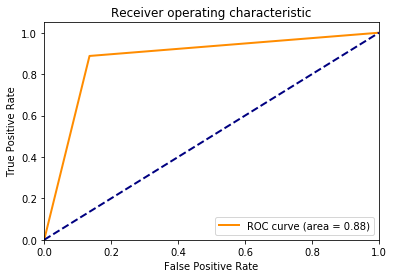

In [382]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

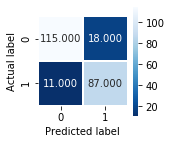

In [383]:
cm = metrics.confusion_matrix(Y_test, test_prediction)
plt.figure(figsize=(2,2))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');

## 4.2 Las losowy

In [384]:
clf = ensemble.RandomForestClassifier(max_depth=5,n_estimators=100)

In [385]:
clf = clf.fit(train, Y_train)

In [386]:
test_prediction = clf.predict(test)

In [387]:
fpr, tpr, thresholds = metrics.roc_curve(Y_test, test_prediction)
roc_auc = metrics.auc(fpr, tpr)

In [388]:
roc_auc

0.8976906552094523

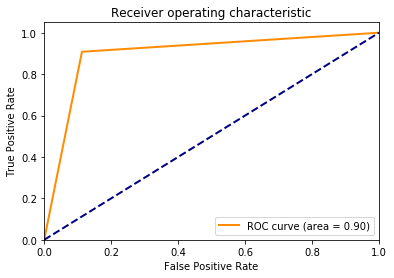

In [389]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

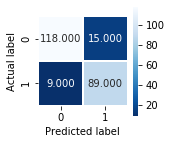

In [390]:
cm = metrics.confusion_matrix(Y_test, test_prediction)
plt.figure(figsize=(2,2))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');

## 4.3 Regresja logistyczna

In [391]:
clf = linear_model.LogisticRegression(max_iter=400, solver="lbfgs")

In [392]:
clf.fit(train, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=400, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [393]:
test_prediction = clf.predict(test)

In [394]:
fpr, tpr, thresholds = metrics.roc_curve(Y_test, test_prediction)
roc_auc = metrics.auc(fpr, tpr)

In [395]:
roc_auc

0.8579484425349088

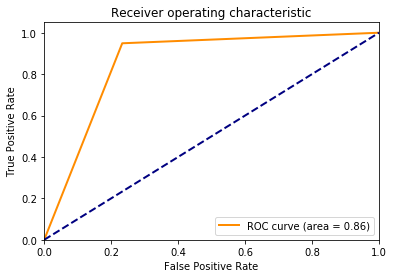

In [396]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

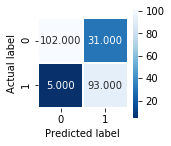

In [397]:
cm = metrics.confusion_matrix(Y_test, test_prediction)
plt.figure(figsize=(2,2))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');

Z mapy wyrzej widać że dostaliśmy nie tak dużo "false positive", jak "false negative" resultatów, co jest dopuszczalne w przypadku naszej analizy udzieliana kredytów, 
chociaż i tak ta metoda pokazała siebie gorzej niż te co mamy wyżej.

In [398]:
gb = ensemble.GradientBoostingClassifier(n_estimators=20, learning_rate = 0.5, max_features=2, max_depth = 2, random_state = 0)

In [399]:
gb.fit(train, Y_train)
test_prediction = gb.predict(test)

In [400]:
fpr, tpr, thresholds = metrics.roc_curve(Y_test, test_prediction)
roc_auc = metrics.auc(fpr, tpr)

In [401]:
roc_auc

0.9001074113856069

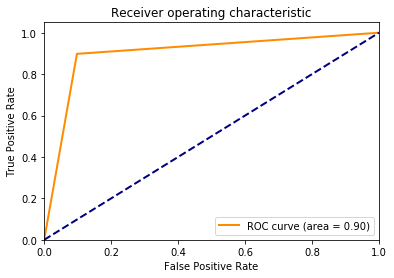

In [402]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

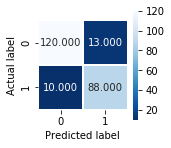

In [403]:
cm = metrics.confusion_matrix(Y_test, test_prediction)
plt.figure(figsize=(2,2))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');

# Wnioski
Analizując otrzymane wyniki można powiedzieć że metoda lasa losowego i drzewa decyzyjnego dali bardzo blizkie wyniki. W przypadku regresji logistycznej otrzymaliśmy nieco gorsze wyniki, co widać z krzywej ROC. POodczas analizowania wydajności tych modeli było wykryte że 4 modeli dają podobne "false positive" błędy. Gradient boosting dał troszki lepsze winiki, ale znowu otrzymaliśmy dużo "false positive" wyników.

Analizując powyzsą pracę można powiedzieć że był osiągnięty wystarczający poziom predykcji cechi

Można poliepszyć rezultat jeżeli:
- zwiększyć bazę wiedzy, przez dodanie dodatkowych wierszy.
- Wykonać bardziej skuteczne przygotowanie danych
   - Użyć bardziej zaawansowanych metod uzupełnienia braków danych
   - Pozbyć się danych które mają duże odchylenie od pozostałych

In [217]:
# 0.81
# CAP miara
# LIFT
# Akaike, AIC, Testy
# regresia logistyczna Y - 0 1 zmienna, X - z modelu
# REC curve dla ciągłych dannych
# dla zmiennych ciągłych spróbiwać REC

In [ ]:
# PREZENTACJA DANYCH : Siatka pomocnicza jedną zmienną zmieniamy a pozostałe zostają, wtedy widzimy jak to wpływa
# 